This notebook is used for testing the posibilities of the data augmentation in keras. The functionality will added to the 2D/3D networks once the tests are done. 

In [1]:
# general imports
import sys,os,time,random
from os import walk
import pickle

# scientific computing
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
import skimage
from skimage.io import imread, imsave
import scipy

from __future__ import print_function
# machine learning stuff
import tensorflow as tf
import keras 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.6
tensorflow 1.0.0


In [4]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [5]:
# Setup for the gpu: 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

In [6]:
# check the output of the command above
tf.device("/gpu:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# this pone should help with the images of the large size
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [7]:
# this part is necessary to set the params from the command line
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=32, help='Number of samples (N) in train and valid')
# TODO: Is it used ? 
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
# TODO: Is it used ?
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="sq", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=1, help='This is the covariance when kern=gaus')
parser.add_argument('-scale', type=int, nargs='?',default=1, help='Scale the input image and labels')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')

args = parser.parse_args()

In [8]:
# set the passed parameters here if you forgot them
args.framesize = 256
args.scale = 1
args.nsamples = 32

print(args)
print(keras.backend.image_data_format())

Namespace(cov=1, data='cells', framesize=256, kern='sq', lr=5e-05, nsamples=32, scale=1, seed=0, stride=1)
channels_last


In [9]:
# how much to extend the initial image 
patch_size = int(32)
framesize = int(args.framesize/args.scale)
channels = int(1)
framesize_h = framesize_w = framesize
noutputs = 1

In [10]:
paramfilename = str(args.scale) + "-" + str(patch_size) + "-" + args.data + "-" + args.kern + str(args.cov) + "_params.p"
datasetfilename = str(args.scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + args.kern + str(args.stride) + "-" + args.data + "-" + str(args.cov) + "-dataset.p"
print(paramfilename)
print(datasetfilename)

1-32-cells-sq1_params.p
1-32-256-sq1-cells-1-dataset.p


In [11]:
#reproducibility
random.seed(args.seed)
np.random.seed(args.seed)
tf.set_random_seed(args.seed)

In [12]:
if (args.kern == "sq"):
    ef = ((patch_size/args.stride)**2.0)
elif (args.kern == "gaus"):
    ef = 1.0
print("ef", ef)

ef 1024.0


In [14]:
# input shape is the image shape without the pathces
input_shape = (framesize, framesize, channels)
ext_shape = (input_shape[0] + patch_size, input_shape[0] + patch_size, channels)

print (input_shape, ext_shape)

(256, 256, 1) (288, 288, 1)


In [125]:
# fucntions to see the results 
def genGausImage(framesize, mx, my, cov=1):
    x, y = np.mgrid[0:framesize, 0:framesize]
    pos = np.dstack((x, y))
    mean = [mx, my]
    cov = [[cov, 0], [0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(len(markers),k-patch_size/2,l-patch_size/2,cov)
    return gaus_img

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath)
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print("unknown label format")
    
    binsize = [scale,scale]
    out = np.zeros(size)
    for i in range(binsize[0]):
        for j in range(binsize[1]):
            out = np.maximum(lab[i::binsize[0], j::binsize[1]], out)
        
    print(lab.sum(),out.sum())
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers, x,y,h,w):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, stride, scale):
    
    height = int ((img_pad.shape[0])/args.stride)
    width = int ((img_pad.shape[1])/args.stride)
    print("label size: ", height, width)
    labels = np.zeros((noutputs, height, width))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                count = getCellCountCells(markers, x*args.stride,y*args.stride,patch_size,patch_size)  
                for i in range(0,noutputs):
                    labels[i][y][x] = count[i]

    
    elif (args.kern == "gaus"):
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers[base_y:base_y+width,base_x:base_x+width])
    

    count_total = getCellCountCells(markers, 0,0,framesize_h+patch_size,framesize_w+patch_size)
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_x,  base_y, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    img_pad = np.pad(img[:,:,0], int ((patch_size)/2), "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:2])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    markers = np.pad(markers, patch_size, "constant", constant_values=-1)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, args.stride, scale)
    return img, labels, count

In [16]:
# read the files from the test folder 
import glob

prefix = '/Users/kkolyva/'
# prefix = '/home/milkyklim/Documents/other'
path = prefix + 'Desktop/2017-10-22-19-39-34-data/'
folder = prefix + 'Desktop/2017-10-22-19-39-34-data/'
folder_images = 'images/'
folder_labels = 'labels/'
img_ext = '.tif'

print('Images path:', path + folder_images)
print('Labels path:', path + folder_labels)

imgs = []

for filename in glob.iglob(folder + "labels/dots*" + img_ext):
    imgg = filename.replace("labels/dots","images/cells")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Images path: /Users/kkolyva/Desktop/2017-10-22-19-39-34-data/images/
Labels path: /Users/kkolyva/Desktop/2017-10-22-19-39-34-data/labels/


In [17]:
# read the files from the test folder 
import glob

prefix = '/Users/kkolyva/'
# prefix = '/home/milkyklim/Documents/other'
folder = prefix + 'dl-cell-counting/algorithm/data/test-cells'
img_ext = '.png'

print('Full path:', folder)

imgs = []

for filename in glob.iglob(folder + "/*dots" + img_ext):
    imgg = filename.replace("dots","cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Full path: /Users/kkolyva/dl-cell-counting/algorithm/data/test-cells


In [18]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print(path, "bad", path[0])
    if (not os.path.isfile(path[1])):
        print(path, "bad", path[1])

In [129]:
dataset = []
if (os.path.isfile(datasetfilename)):
    print("reading", datasetfilename)
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    print(len(imgs))
    for path in imgs: 

        imgPath = path[0]
        print(imgPath)

        im = imread(imgPath)
        img_raw_raw = im; # im[:, :, None] # .transpose([1,2,0])
        
        # img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale),int(img_raw_raw.shape[1]/args.scale)))
        img_raw = img_raw_raw
        print(img_raw_raw.shape," ->>>>", img_raw.shape)

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize_h):
            for base_y in range(0,img_raw.shape[1],framesize_w):
                
                if (img_raw.shape[1] - base_y < framesize_w) or (img_raw.shape[0] - base_x < framesize_h):
                    print("!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x)
                    continue
                    
                img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_y, base_x, args.stride, args.scale)
                print("count ", count)
                    
                if img.shape[0:2] != (framesize_w,framesize_h):
                    print("!!!! Not adding image because size is" , img.shape[0:2])
                    
                else :   
                    lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
                
                    assert np.allclose(count,lab_est, 0)
                
                    dataset.append((img,lab,count))
                    
                    print("lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape)
                    sys.stdout.flush()
                    
        print("dataset size", len(dataset))
                    
    print("writing", datasetfilename)
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print("DONE")

reading 1-32-256-sq1-cells-1-dataset.p
DONE


In [130]:
# grab the data from the data set
np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=np.float32)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=np.float32)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=np.float32)

# np_dataset_x = np_dataset_x.transpose((0,3,1,2))

print("np_dataset_x", np_dataset_x.shape)
print("np_dataset_y", np_dataset_y.shape)
print("np_dataset_c", np_dataset_c.shape)

np_dataset_x (200, 256, 256, 3)
np_dataset_y (200, 1, 288, 288)
np_dataset_c (200, 1)


In [131]:
length = len(np_dataset_x)

# 2/3 vs 1/3 for training and validation
n = int (args.nsamples / 3); 

np_dataset_x_train = np_dataset_x[0:2*n]
np_dataset_y_train = np_dataset_y[0:2*n]
np_dataset_c_train = np_dataset_c[0:2*n]
print("np_dataset_x_train", len(np_dataset_x_train))

np_dataset_x_valid = np_dataset_x[2*n:3*n]
np_dataset_y_valid = np_dataset_y[2*n:3*n]
np_dataset_c_valid = np_dataset_c[2*n:3*n]
print("np_dataset_x_valid", len(np_dataset_x_valid))

np_dataset_x_test = np_dataset_x[3*n:]
np_dataset_y_test = np_dataset_y[3*n:]
np_dataset_c_test = np_dataset_c[3*n:]
print("np_dataset_x_test", len(np_dataset_x_test))

np_dataset_x_train 20
np_dataset_x_valid 10
np_dataset_x_test 170


(20, 256, 256, 3) (20, 256, 3, 256)
(9, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


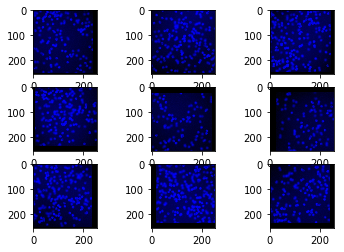

In [135]:
# define data preparation
# define data preparation
shift = 0.1
datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             # rotation_range=90,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'constant',
                             cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)
# fit parameters from data

print(np_dataset_x_train.shape, np_dataset_x_train.transpose((0, 2,3,1)).shape)

datagen.fit(np_dataset_x_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(np_dataset_x_train, np_dataset_y_train, batch_size=9):
    # , save_to_dir='images', save_prefix='aug', save_format='png'):
    print(X_batch.shape)  
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        img = np.array(X_batch[i].reshape(framesize, framesize, 3), dtype=np.float32).astype(np.uint8)
        print(img.shape)  
        plt.imshow(img, cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [132]:
np_dataset_y_train = np_dataset_y_train.transpose([0,2,3,1])
np_dataset_y_train.shape

(20, 288, 288, 1)

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20, 288, 288, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


ValueError: total size of new array must be unchanged

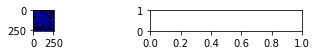

In [139]:
# in case of images and labels we have to use the following approach: 
# create 2 instances with the same arguments: 
shift = 0.02
image_data_gen_args = dict(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             # rotation_range=90,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'constant',
                             cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)
datagen = ImageDataGenerator(**image_data_gen_args)
labelgen = ImageDataGenerator(**image_data_gen_args)

seed = args.seed
datagen.fit(np_dataset_x_train, augment=True, seed=seed)
# change this one to labels
labelgen.fit(np_dataset_y_train, augment=True, seed=seed)

image_generator = datagen.flow(
    np_dataset_x_train,
    seed=seed, 
    save_to_dir='data/aug', save_prefix='cells', save_format='png')
label_generator = labelgen.flow(
    np_dataset_y_train,
    seed=seed,
    save_to_dir='data/aug', save_prefix='dots', save_format='png')

# plt.rcParams['figure.figsize'] = (9, 5)

for X_batch, y_batch in zip(image_generator, label_generator):
    # , save_to_dir='images', save_prefix='aug', save_format='png'): 
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(9, 2, 0 + 1 + 2*i) 
        plt.figsize=(18, 9)
        img = np.array(X_batch[i].reshape(framesize, framesize, 3), dtype=np.float32).astype(np.uint8)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        
        plt.subplot(9, 2, 0 + 1 + 2*i + 1) 
        img = np.array(y_batch[i].reshape(framesize, framesize, 1), dtype=np.float32).astype(np.uint8)
        plt.imshow(img, cmap=plt.get_cmap('gray'))          
    # show the plot
    plt.show()
    break


# combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)
# model.fit_generator( train_generator, 
#     steps_per_epoch=2000,
#     epochs=50)

TypeError: 'NumpyArrayIterator' object is not subscriptable

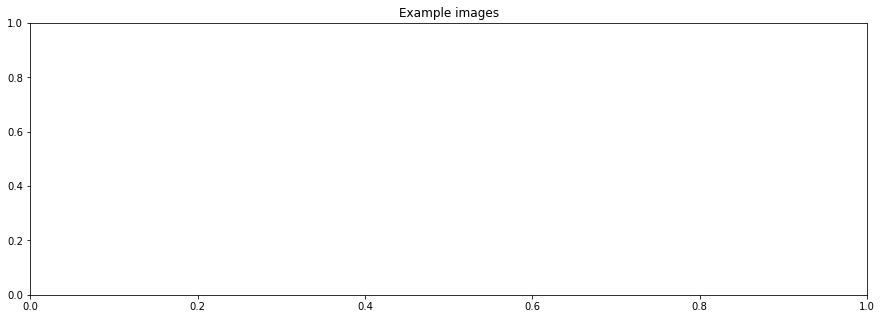

In [57]:
# examples of the images from the training set 
n_images_show = 7
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(image_generator[:n_images_show].astype(np.uint8),axis=1), interpolation='none');

In [59]:
?image_generator